# Train SVR (Support Vector Regression) model on kss events

Train SVR and evaluate against training set

This is to verify the algorithms are working.
Validation is onde manually and will come later.


In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.font_manager as mfm
from display import Disp
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline

from audio import Audio
from kss_df import KssDf
from transformers import SlidingWindow

font_path = '/Users/dev/Fonts/Noto_Sans_KR/NotoSansKR-Regular.otf'
k_prop = mfm.FontProperties(fname=font_path)
plt.style.use('dark_background')

# Display handler with some nice helpers
disp = Disp(display)
# Uncomment to see the source code
# disp.code('display.py', label='display.py ')


# disp examples
# disp(IPython.display.Audio('./data/korean-single-speaker/kss/1/1_0000.wav'))
# disp_file_source('marker_df.py', label='marker_df')
# disp_audio_file('./data/korean-single-speaker/kss/1/1_0000.wav', label='1_0000.wav')

## Load Training Data

In [12]:
from filename_versioner import FilenameVersioner

import joblib
tng_data_dir = './data/model'

fv_xy = FilenameVersioner(('xy_trn_rms', 'joblib'), base_dir=tng_data_dir)
fv_shared_params = FilenameVersioner(('shared_params', 'joblib'), base_dir=tng_data_dir)

xy_file_base, xy_vsn = fv_xy.get_latest_data()
shared_params_file_base, shared_params_vsn = fv_shared_params.get_latest_data()
#TODO: Rename to trainingg_versions
training_version = f'xy{xy_vsn}p{shared_params_vsn}'

xy_file = f'{fv_xy.base_dir}/{xy_file_base}'
disp.obj(xy_file, 'X file name')
shared_params_file = f'{fv_shared_params.base_dir}/{shared_params_file_base}'
disp.obj(shared_params_file, 'y file name')
# x_file = f'{fv_x.base_dir}/{x_file_base}'
# disp.obj(x_file, 'X file name')
# y_file = f'{fv_y.base_dir}/{y_file_base}'
# disp.obj(y_file, 'y file name')
# TODO: Remove tuple from X data
# X_train, _ = joblib.load(x_file)
# y_train = joblib.load(y_file)
X_train, y_train = joblib.load(xy_file)



disp.obj(X_train, label='X')
disp.obj(y_train, label='y')
disp.obj((X_train.shape, np.mean(X_train)), label='X shape, mean' )
disp.obj((y_train.shape, np.mean(y_train)), label='y shape, mean')

X file name

'./data/model/xy_trn_rms.0.joblib'

y file name

'./data/model/shared_params.0.joblib'

X

array([7.2832445e-05, 8.1853534e-05, 8.1345970e-05, ..., 3.1566969e-03,
       2.6764204e-03, 1.7978763e-03], dtype=float32)

y

array([False, False, False, ..., False, False, False])

X shape, mean

((7976,), 0.23565763)

y shape, mean

((7976,), 0.8134403209628887)

## Train Model and Save: SVR (Support Vector Regression)

We wrap the model in a pipeline as we need to do some transformations (creating windowed features for X).

In [13]:
from pipewrap import PipeWrap


sliding_window = SlidingWindow(offset=64, window=128)
disp.obj(sliding_window, label='SlidingWindow')


# Models and processing
svr_rbf = SVR(kernel='rbf', C=50, gamma=0.2, epsilon=0.1, verbose=4)
# Using sklearn pipeline creates a problem with comparing saved model vs current model since the model instance is
# returned with `pipe.get_params`, rather than the model parameters. I need to figure out a way to get around that
# in order to prevent unnecessary model updates.
# from transformers import SlidingWindow
steps = [('sw', sliding_window), ('svr_rbf', svr_rbf)]
pw = PipeWrap(steps)


SlidingWindow

SlidingWindow(offset=64, window=128)

In [14]:
print(X_train.size)
print(y_train.size)
pw.pipe.fit(X_train, y_train)

SlidingWindow[DEBUG]: Initial X shape: (7976,)
SlidingWindow[DEBUG]: Pad Size: (64, 191)
SlidingWindow[DEBUG]: Padded X: (8231,)
SlidingWindow[INFO]: np sliding window shape: (8104, 128)
SlidingWindow[DEBUG]: Initial y shape: (7976,)
SlidingWindow[DEBUG]: final y shape: (7976,)
SlidingWindow[DEBUG]: Final X shape: (7976, 128)
SlidingWindow[DEBUG]: Transform shapes, X: (7976,), y:--
SlidingWindow[DEBUG]: Pad Size: (64, 191)
SlidingWindow[DEBUG]: Padded X: (8231,)
SlidingWindow[DEBUG]: X shape: (7976,), fitted shape: (8104, 128)
SlidingWindow[DEBUG]: X shape: (7976,), fitted shape: (7976, 128)


7976
7976
[LibSVM]

Pipeline(steps=[('sw', SlidingWindow(offset=64, window=128)),
                ('svr_rbf', SVR(C=50, gamma=0.2, verbose=4))])

In [19]:
# Set up the model for saving
tng_data_dir = './data/model'
model_file = f'svr_rbf.{training_version}'
fv = FilenameVersioner((model_file, 'joblib'), base_dir=tng_data_dir )

saved_model_path = fv.get_latest_path()
print(saved_model_path)

saved_wrap = joblib.load(saved_model_path) if saved_model_path else None


# Save the pipeline so we can modify it later without changing this code
if saved_wrap is None or pw.params != saved_wrap.params:
    print('Detected new trained model')
    versioned_model_file = fv.increment_version()
    print(f'saving model as {versioned_model_file}')
    joblib.dump(pw, versioned_model_file)
else:
    print('No changes detected')


./data/model/svr_rbf.xy0p0.0.joblib
No changes detected


## Evaluate Training

Evaluate the training data by seeing if our trained model will predict close to the data it was trained on.

Validation will come later

This is just to make sure our Model trained correctly. It might have overfit, but we don't care yet.

In [20]:
# TODO: Move these into a class
def pred_threshold(pred_vals, thresh=0.5):
    return np.where(pred_vals > thresh, True, False)

y_train_pred = saved_wrap.pipe.predict(X_train)

SlidingWindow[DEBUG]: Transform shapes, X: (7976,), y:--
SlidingWindow[DEBUG]: Pad Size: (64, 191)
SlidingWindow[DEBUG]: Padded X: (8231,)
SlidingWindow[DEBUG]: X shape: (7976,), fitted shape: (8104, 128)
SlidingWindow[DEBUG]: X shape: (7976,), fitted shape: (7976, 128)


Pipeline(steps=[('sw', SlidingWindow(offset=64, window=128)),
                ('svr_rbf', SVR(C=50, gamma=0.2, verbose=4))])


In [21]:
shared_params = joblib.load(fv_shared_params.get_latest_path())
# remove kss_ids from params just to keep things a bit cleaner
kss_ids = shared_params['kss']['trn_ids']
print(kss_ids)
audio_params = shared_params['audio']
# iterate over each kss_id, find the audio file, load it and return it's squeezed rms
x_rms = np.concatenate([Audio(KssDf(id).audio_path, **audio_params).rms.squeeze() for id in kss_ids])

sw_mean_offset = sliding_window.window-sliding_window.offset
sw_offset = 0

def align(y, offset):
    return np.pad(y, (offset, 0), 'minimum')

def delta(y1, y2, y1_offset, y2_offset):
    min_len = min(len(y1), len(y2))
    return align(y1, y1_offset)[0:min_len] - align(y2, y2_offset)[0:min_len]

def speech_base_delta(y, offset):
    return delta(y, y_train, offset, 0)


/Users/dev/Projects/korean-ml/venv/lib/python3.9/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(
Audio[INFO]: a.to_rms size: 2431, reduction factor 2430.0
Audio[WARNING]: Modifying input wav from size 175173 to 175232
Audio[INFO]: change in number of samples: 59 [should be less than hop length: 64]
Audio[INFO]: a.to_rms size: 2739, reduction factor 2738.0
Audio[WARNING]: Modifying input wav from size 77573 to 77632
Audio[INFO]: change in number of samples: 59 [should be less than hop length: 64]
Audio[INFO]: a.to_rms size: 1214, reduction factor 1213.0
Audio[WARNING]: Modifying input wav from size 101762 to 101824
Audio[INFO]: change in number of samples: 62 [should be less than hop length: 64]
Audio[INFO]: a.to_rms size: 1592, reduction factor 1591.0


['1_0000', '1_0001', '1_0002', '1_0003']


In [22]:
sw_pipe = Pipeline([('sw', pw.pipe.named_steps['sw'])])
x_sw = sw_pipe.transform(X_train)

SlidingWindow[DEBUG]: Transform shapes, X: (7976,), y:--
SlidingWindow[DEBUG]: Pad Size: (64, 191)
SlidingWindow[DEBUG]: Padded X: (8231,)
SlidingWindow[DEBUG]: X shape: (7976,), fitted shape: (8104, 128)
SlidingWindow[DEBUG]: X shape: (7976,), fitted shape: (7976, 128)


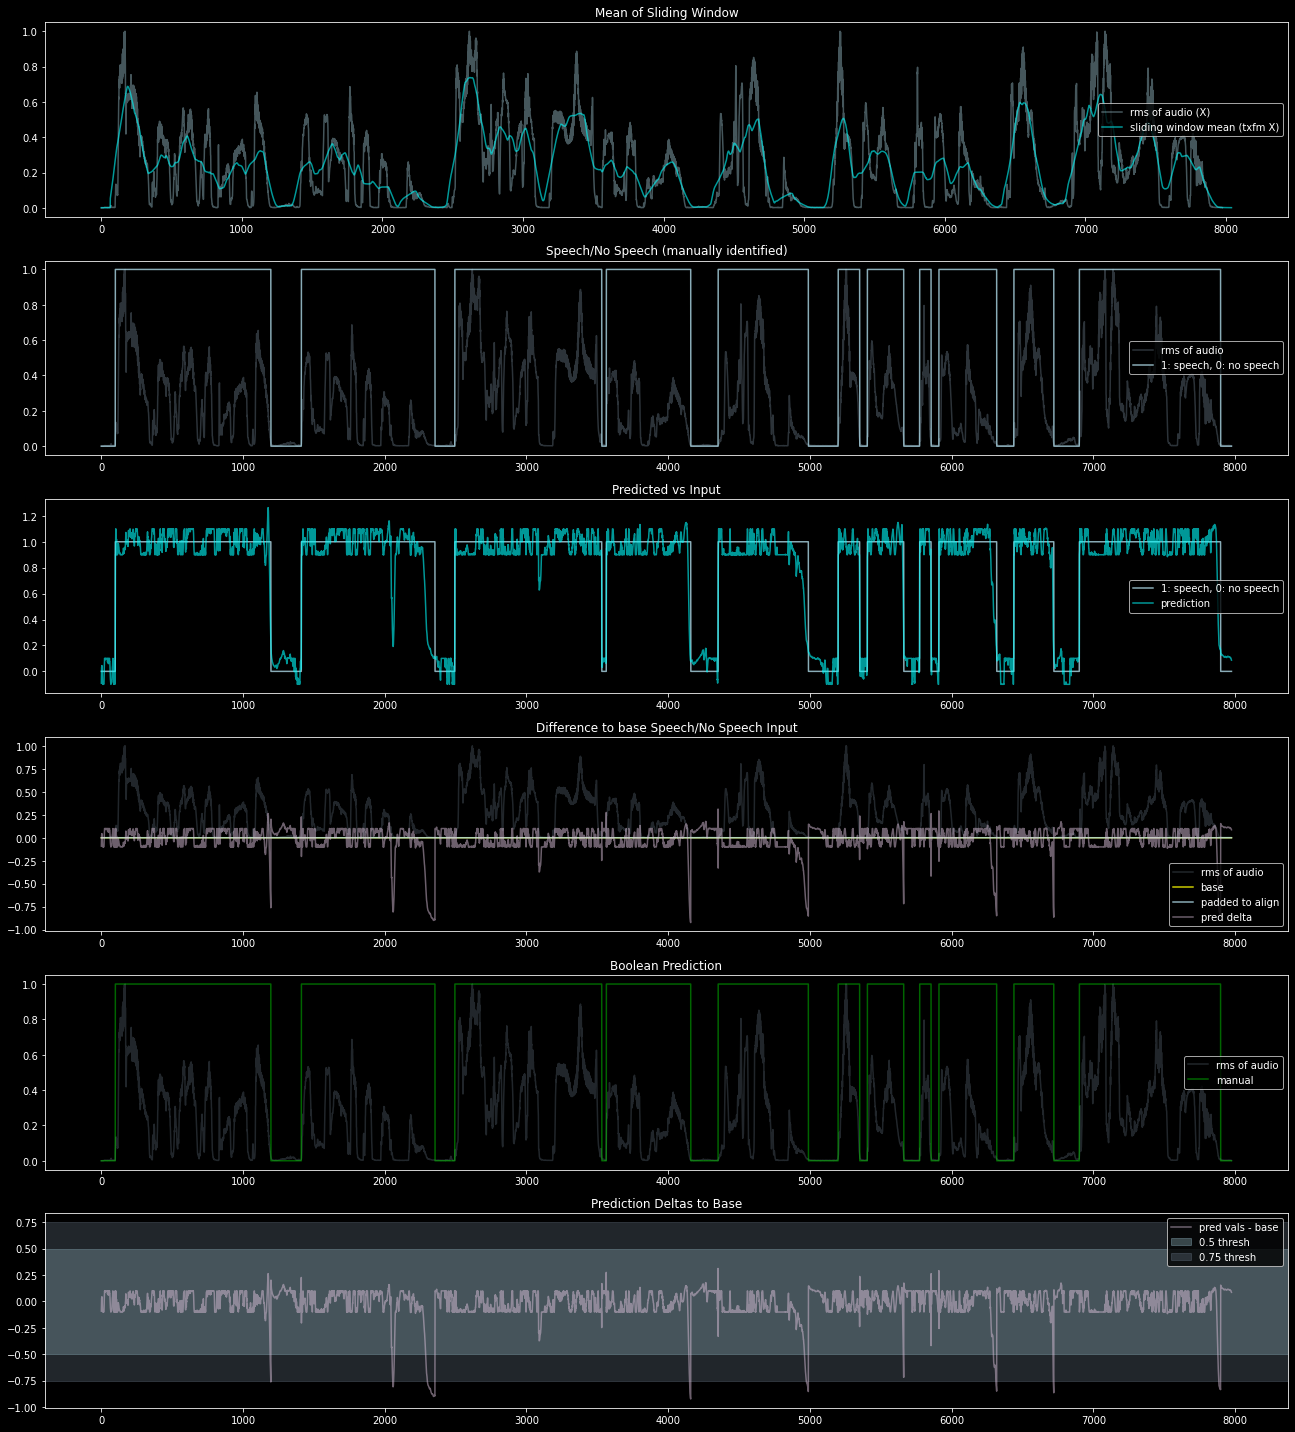

In [23]:
fig, axs  = plt.subplots(6, 1, figsize=(18,20))

axs[0].set_title(f'Mean of Sliding Window')
axs[0].plot(X_train, color='lightblue', alpha=0.4, label='rms of audio (X)')
axs[0].plot(align(np.mean(x_sw, axis=1), sw_mean_offset), color='cyan', alpha=0.6, label='sliding window mean (txfm X)')
axs[0].legend(loc='center right')

axs[1].set_title(f'Speech/No Speech (manually identified)')
axs[1].plot(x_rms, color='slategray', alpha=0.4, label='rms of audio')
axs[1].plot(y_train, color='lightblue', alpha=0.8, label='1: speech, 0: no speech')
axs[1].legend(loc='center right')

axs[2].set_title(f'Predicted vs Input')
axs[2].plot(y_train, color='lightblue', alpha=0.8, label='1: speech, 0: no speech')
axs[2].plot(align(y_train_pred, sw_offset), color='cyan', alpha=0.6, label='prediction')
axs[2].legend(loc='center right')

axs[3].set_title(f'Difference to base Speech/No Speech Input')
axs[3].plot(x_rms, color='slategray', alpha=0.3, label='rms of audio')
axs[3].plot(y_train.astype(int)-y_train.astype(int), color='yellow', alpha=0.8, label='base')
axs[3].plot(speech_base_delta(y_train.astype(int), sw_offset), color='lightblue', alpha=0.8, label="padded to align")
axs[3].plot(speech_base_delta(y_train_pred, sw_offset), color='thistle', alpha=0.5, label='pred delta')
axs[3].legend(loc='lower right')

axs[4].set_title(f'Boolean Prediction')
axs[4].plot(x_rms, color='slategray', alpha=0.3, label='rms of audio')
axs[4].plot(1*pred_threshold(y_train, 0.5), color='lime', alpha=0.4, label='manual')
axs[4].legend(loc='center right')

axs[5].set_title(f'Prediction Deltas to Base')
axs[5].plot(speech_base_delta(y_train_pred, sw_offset), color='thistle', alpha=0.5, label='pred vals - base')
axs[5].axhspan(-0.5, 0.5, color='lightblue', alpha=0.3, label='0.5 thresh'),
axs[5].axhspan(-0.75, 0.75, color='slategray', alpha=0.3, label='0.75 thresh')
axs[5].legend(loc='upper right')

plt.tight_layout()
plt.show()

